# Comparison with EikoGAMMA

In [14]:
from IPython.display import clear_output
!pip install gmma
clear_output()

In [15]:
import pandas as pd
from datetime import datetime, timedelta
import gamma
from gamma.utils import association
import numpy as np
from datetime import datetime, timedelta
import os
import json
import pickle
from tqdm import tqdm
import time
from pyproj import Proj

In [16]:
data_path = lambda x: os.path.join("./", x)
# station_json = data_path("synthetic_stations.json")
station_csv = data_path("scsn_stations.csv")
# pick_csv = data_path("synthetic_picks.csv")
pick_csv = data_path("initial_test.csv")

catalog_csv = data_path("gamma_catalog.csv")
picks_csv = data_path("gamma_picks.csv")
if not os.path.exists("figures"):
    os.makedirs("figures")
figure_dir = lambda x: os.path.join("figures", x)

## read config
# with open("config.json", "r") as f:
#     config = json.load(f)

## read picks
# picks = pd.read_json(pick_json)
picks = pd.read_csv(pick_csv)

## match format with gamma
picks["time"] = picks["time"].apply(lambda x: x+"".join(["0"]*(23 - len(x))))
picks["phase_time"] = picks["time"]
picks["phase_type"] = picks["phase"] 
picks["phase_amp"] = picks["amp"].apply(lambda x: 10**(x)*100)
picks["phase_score"] = 1.0
picks["station_id"] = picks["network"] + "." + picks["station"]
picks["timestamp"]=picks["phase_time"]
picks["amp"]=picks["phase_amp"]
picks["prob"]=picks["phase_score"]
picks["type"]=picks["phase_type"]
picks["timestamp"] = picks["timestamp"].apply(lambda x: datetime.fromisoformat(x))
picks["id"] = picks["station_id"]

## read stations
# stations = pd.read_json(station_json, orient="index")
stations = pd.read_csv(station_csv)

## manually set config to match with eikogamma
# center = stations[["longitude", "latitude"]].mean().values
# xlim = [stations["longitude"].min()-0.1, stations["longitude"].max()+0.1]
# ylim = [stations["latitude"].min()-0.1, stations["latitude"].max()+0.1]
# config = {'center': center, 
#         'xlim_degree': xlim, 
#         'ylim_degree': ylim, 
#         'degree2km': 111.19492474777779}
config = {
    "center": [-117.504, 35.705],
    "xlim_degree": [-118.004, -117.004],
    "ylim_degree": [35.205, 36.205],
    'degree2km': 111.19492474777779
}

stations["id"] = stations.index
stations["id"] = stations["network"] + "." + stations["station"]
# stations.rename(columns={"station": "id"}, inplace=True)
proj = Proj(f"+proj=sterea +lon_0={config['center'][0]} +lat_0={config['center'][1]} +units=km")
stations[["x(km)", "y(km)"]] = stations.apply(lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1)
# stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x / 1e3)
# stations["x(km)"] = stations["longitude"].apply(
#     lambda x: (x - config["center"][0]) * config["degree2km"]
# )
# stations["y(km)"] = stations["latitude"].apply(
#     lambda x: (x - config["center"][1]) * config["degree2km"]
# )
stations["z(km)"] = stations["elevation"]
stations = stations.drop_duplicates(subset='id', keep="first")

## set GMMA configs
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0, 20)
config["starttime"] = picks["timestamp"].min()
config["endtime"] = picks["timestamp"].max()
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = False
config["use_amplitude"] = True
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
config["method"] = "BGMM"
## the computational time is proportional to the oversampling factor
if config["method"] == "BGMM":
    # config["oversample_factor"] = 3
    config["oversample_factor"] = 60
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 10 #seconds
config["dbscan_min_samples"] = min(3, len(stations))

# Filtering hyperparameters
config["min_picks_per_eq"] = 50 * 2
config["max_sigma11"] = 1.0 * 3.0 * 10000.0 ## not using time residual as filtering
config["max_sigma22"] = 0.5 * 2.0 * 10000.0 ## not using amplitude as filtering

for k, v in config.items():
    print(f"{k}: {v}")


center: [-117.504, 35.705]
xlim_degree: [-118.004, -117.004]
ylim_degree: [35.205, 36.205]
degree2km: 111.19492474777779
vel: {'p': 6.0, 's': 3.4285714285714284}
dims: ['x(km)', 'y(km)', 'z(km)']
x(km): [-55.59746237  55.59746237]
y(km): [-55.59746237  55.59746237]
z(km): (0, 20)
starttime: 1986-11-20 00:00:00.172000
endtime: 1986-11-20 00:01:59.677000
use_dbscan: False
use_amplitude: True
method: BGMM
oversample_factor: 60
bfgs_bounds: ((-56.597462373888895, 56.597462373888895), (-56.597462373888895, 56.597462373888895), (0, 21), (None, None))
dbscan_eps: 10
dbscan_min_samples: 3
min_picks_per_eq: 100
max_sigma11: 30000.0
max_sigma22: 10000.0


## 2. Associaiton with GaMMA

In [17]:
start_time = time.time()

event_idx0 = 0 ## current earthquake index
assignments = []
catalogs, assignments = association(picks, stations, config, event_idx0, config["method"])
event_idx0 += len(catalogs)

## create catalog
catalogs = pd.DataFrame(catalogs, columns=["time"]+config["dims"]+["magnitude", "sigma_time", "sigma_amp", "cov_time_amp",  "event_index", "gamma_score"])
catalogs["longitude"] = catalogs["x(km)"].apply(
    lambda x: x / config["degree2km"] + config["center"][0]
)
catalogs["latitude"] = catalogs["y(km)"].apply(
    lambda x: x / config["degree2km"] + config["center"][1]
)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
with open(catalog_csv, 'w') as fp:
    catalogs.to_csv(fp,index=False, 
                    float_format="%.3f",
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["time", "magnitude", "longitude", "latitude", "depth(m)", "sigma_time", "sigma_amp", "cov_time_amp", "event_index", "gamma_score"])
# catalogs = catalogs[['time', 'magnitude', 'longitude', 'latitude', 'depth(m)', 'sigma_time', 'sigma_amp', 'gamma_score']]

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({'event_index': int})
with open(picks_csv, 'w') as fp:
    picks.to_csv(fp, index=False, 
                    date_format='%Y-%m-%dT%H:%M:%S.%f',
                    columns=["station_id", "phase_time", "phase_type", "phase_score", "phase_amp", "event_index", "gamma_score"])

print(f"Total time: {time.time() - start_time} seconds")


Process 910 picks: 100%|██████████| 910/910 [00:01<00:00, 676.12it/s]

Total time: 1.371797800064087 seconds


## 3. Visualize results

Note that the location and magnitude are estimated during associaiton, which are not expected to have high accuracy. 

In [18]:
stations["station_id"] = stations["id"]
picks = pd.merge(picks, stations, on="station_id", how="left")

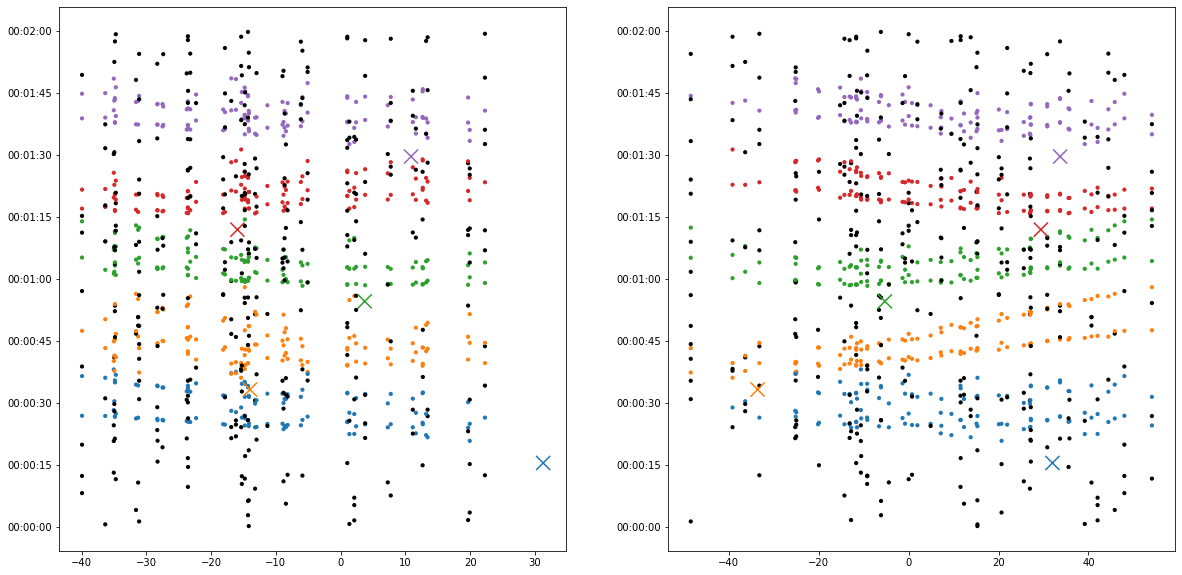

In [19]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter( picks["x(km)"], picks["timestamp"], c=[f"C{i}" if i!= -1 else "k" for i in picks["event_index"] ], s=10)
plt.scatter(catalogs["x(km)"], catalogs["time"],  c=[f"C{i}" if i!= -1 else "k" for i in catalogs["event_index"] ], s=200, marker="x")

# plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 2)
plt.scatter(picks["y(km)"], picks["timestamp"],  c=[f"C{i}" if i!= -1 else "k" for i in picks["event_index"] ], s=10)
plt.scatter(catalogs["y(km)"], catalogs["time"], c=[f"C{i}" if i!= -1 else "k" for i in catalogs["event_index"] ], s=200, marker="x")

In [20]:
print("Total picks:", len(picks))
print("Associated picks:", len(picks[picks["event_index"] != -1]))

Total picks: 910
Associated picks: 588
